In [ ]:
def cut(line, distance):
# Cuts a line in two at a distance from its starting point
# Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

### Downloading and stacking PIXC tiles

In [1]:
# import fiona
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set-up
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/'

In [3]:
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

In [4]:
# Get slurm job index
i = 109

# Get current HUC2 and HUC4 IDs
hu2 = 'HUC2_' + lookup.loc[i,'HUC4'][0:2]
hu4 = 'NHDPLUS_H_' + lookup.loc[i,'HUC4'] + '_HU4_GDB'

In [5]:
# Set data filepath
file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg')

In [ ]:
# fiona.listlayers(file_path)

In [ ]:
# fieldsF = ['GNIS_ID', 'GNIS_Name', 'LengthKM',  'FlowDir',
#            'WBArea_Permanent_Identifier', 'FType', 'FCode',
#            'NHDPlusID', 'VPUID', 'geometry']
# fieldsVAA = ['NHDPlusID', 'StreamOrde', 'FromNode', 'ToNode',
#             'LevelPathI', 'TerminalFl', 'TotDASqKm', 'VPUID']
# fieldsEROMMA = ['NHDPlusID', 'QBMA', 'VPUID']

In [6]:
# Read in NHD flowlines
features = ['NHDPlusID', 'LengthKM', 'WidthM', 'Bin', 'geometry']
basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')

In [7]:
basin.shape

(239499, 5)

In [8]:
# Drop reaches that are shorter than their width
basin = basin[basin['LengthKM']*1000 > basin['WidthM']]

In [9]:
basin.shape

(238500, 5)

#### Width analysis

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
basin.plot(ax=ax)
# basin[basin['LengthKM'] == 16.387000].plot(color='r', ax=ax)

In [100]:
basin.Bin.unique()

array(['(0, 10]', '(10, 20]', '(40, 50]', '(50, 60]', '(20, 30]',
       '(30, 40]', '(90, 100]', '(70, 80]', '(60, 70]', '(80, 90]'],
      dtype=object)

In [101]:
# order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
#          '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
#          '(100, 150]', '(150, 200]']
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(80, 90]']

Text(0, 0.5, 'Number of reaches')

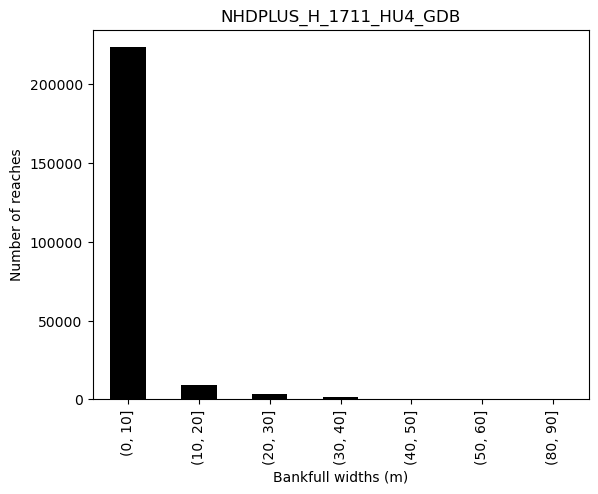

In [102]:
basin['Bin'].value_counts().loc[order].plot.bar(color='k')
plt.title(hu4)
plt.xlabel('Bankfull widths (m)')
plt.ylabel('Number of reaches')

In [103]:
min_width = basin.groupby('Bin').min('LengthKM')['LengthKM']
mean_width = basin.groupby('Bin').mean('LengthKM')['LengthKM']
med_width = basin.groupby('Bin').median('LengthKM')['LengthKM']
max_width = basin.groupby('Bin').max('LengthKM')['LengthKM']

print('Reach length by bin\n')
print('Width (m)\t' +  'Min(m)\t' + 'Mean(m)\t' + 'Med(m)\t' + 'Max(m)\t')
for i in order:
    print(i + ':\t' + str(round(min_width.loc[i], 3)*1000) + '\t' +
          str(round(mean_width.loc[i], 3)*1000) + '\t' +
          str(round(med_width.loc[i], 3)*1000) + '\t' +
          str(round(max_width.loc[i], 3)*1000))

Reach length by bin

Width (m)	Min(m)	Mean(m)	Med(m)	Max(m)	
(0, 10]:	2.0	348.0	252.0	10111.0
(10, 20]:	11.0	327.0	188.0	7801.0
(20, 30]:	21.0	306.0	193.0	7040.0
(30, 40]:	32.0	370.0	238.0	4541.0
(40, 50]:	42.0	560.0	332.0	4824.0
(50, 60]:	52.0	705.0	482.0	5667.0
(80, 90]:	430.0	720.0	762.0	968.0


In [105]:
basin[basin['LengthKM'] > 8.0]

,Permanent_Identifier,FDate,Resolution,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FlowDir,WBArea_Permanent_Identifier,FType,...,AvgQAdjMA,GageIDMA,GageQMA,DIVISION,phys_div,a,b,WidthM,Bin,geometry
122007,130845099,2018-01-02 00:00:00+00:00,2,01508854,Swan Creek,10.110851,17110014000548,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,6.688119,"(0, 10]",MULTILINESTRING Z ((-13624848.401 5966625.882 ...
204819,165519688,2012-02-26 20:06:24+00:00,2,01509284,Wapato Creek,9.656000,17110019020834,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,7.774163,"(0, 10]",MULTILINESTRING Z ((-13616401.098 5979018.668 ...


In [17]:
reach = basin.loc[basin['LengthKM'] > 10]

In [ ]:
reach

,Bin,LengthKM,NHDPlusID,WidthM,geometry
122007,"(0, 10]",10.110851,5.500080e+13,6.688119,MULTILINESTRING Z ((-13624848.401 5966625.882 ...


In [68]:
test = reach.LengthKM.item()

In [74]:
print(reach.GNIS_Name.item() + ", " + reach.Permanent_Identifier.item() +
          ", Length: " + str(round(reach.LengthKM.item(),3)) + "km, Width: " +
          str(round(reach.WidthM.item(),3)) + 'm')

Swan Creek, 130845099, Length (km): 10.111, Width (m): 6.688


In [ ]:
reach = basin[basin['LengthKM'] > 10];

fig, ax = plt.subplots(figsize=(15,15))
basin.plot(ax=ax)
reach.plot(color='r', ax=ax)
plt.title(reach.GNIS_Name.item() + ", " + reach.Permanent_Identifier.item() +
          ", Length: " + str(round(reach.LengthKM.item(),3)) + "km, Width: " +
          str(round(reach.WidthM.item(),3)) + 'm')

In [87]:
basin.shape

(239499, 90)

In [86]:
basin[basin['LengthKM']*1000 < basin['WidthM']*20]

,Permanent_Identifier,FDate,Resolution,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FlowDir,WBArea_Permanent_Identifier,FType,...,AvgQAdjMA,GageIDMA,GageQMA,DIVISION,phys_div,a,b,WidthM,Bin,geometry
3,130926539,2012-02-27 07:04:15+00:00,2,None,None,0.108000,17110015000916,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,8.022535,"(0, 10]",MULTILINESTRING Z ((-13633496.17 5917815.181 0...
39,166123593,2016-01-26 00:00:00+00:00,2,01533598,Nisqually River,0.385107,17110015000054,1,130937104,558,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,45.621628,"(40, 50]","MULTILINESTRING Z ((-13627721.446 5917351.5 0,..."
91,129071186,2012-02-26 06:22:24+00:00,2,None,None,0.068000,17110008000387,1,129073091,558,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,4.810250,"(0, 10]",MULTILINESTRING Z ((-13612589.99 6143780.577 0...
94,165292260,2012-02-26 06:20:59+00:00,2,01531552,Freedom Creek,0.032000,17110008000348,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,2.882000,"(0, 10]",MULTILINESTRING Z ((-13612167.628 6153592.522 ...
117,166125173,2012-02-27 07:00:31+00:00,2,01522260,Little Mashel River,0.117000,17110015000162,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,14.223515,"(10, 20]",MULTILINESTRING Z ((-13610994.341 5917158.493 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239481,129372882,2012-02-26 06:31:33+00:00,2,01523090,Middle Fork South Fork Sultan River,0.007000,17110009000562,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,5.509178,"(0, 10]",MULTILINESTRING Z ((-13536990.232 6094884.632 ...
239483,129372299,2012-02-26 06:33:21+00:00,2,01526262,South Fork Sultan River,0.054000,17110009000420,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,10.236664,"(10, 20]",MULTILINESTRING Z ((-13539013.34 6097918.174 0...
239495,129067084,2012-02-26 06:20:31+00:00,2,01523850,North Fork Stillaguamish River,0.230000,17110008000198,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,12.437127,"(10, 20]",MULTILINESTRING Z ((-13538178.016 6171320.073 ...
239496,165299337,2012-02-26 06:20:31+00:00,2,01523850,North Fork Stillaguamish River,0.150000,17110008000198,1,None,460,...,0.0,0,0.0,PACIFIC MOUNTAIN SYSTEM,PMS,2.76,0.399,12.401194,"(10, 20]",MULTILINESTRING Z ((-13538207.484 6171515.165 ...


<Axes: >

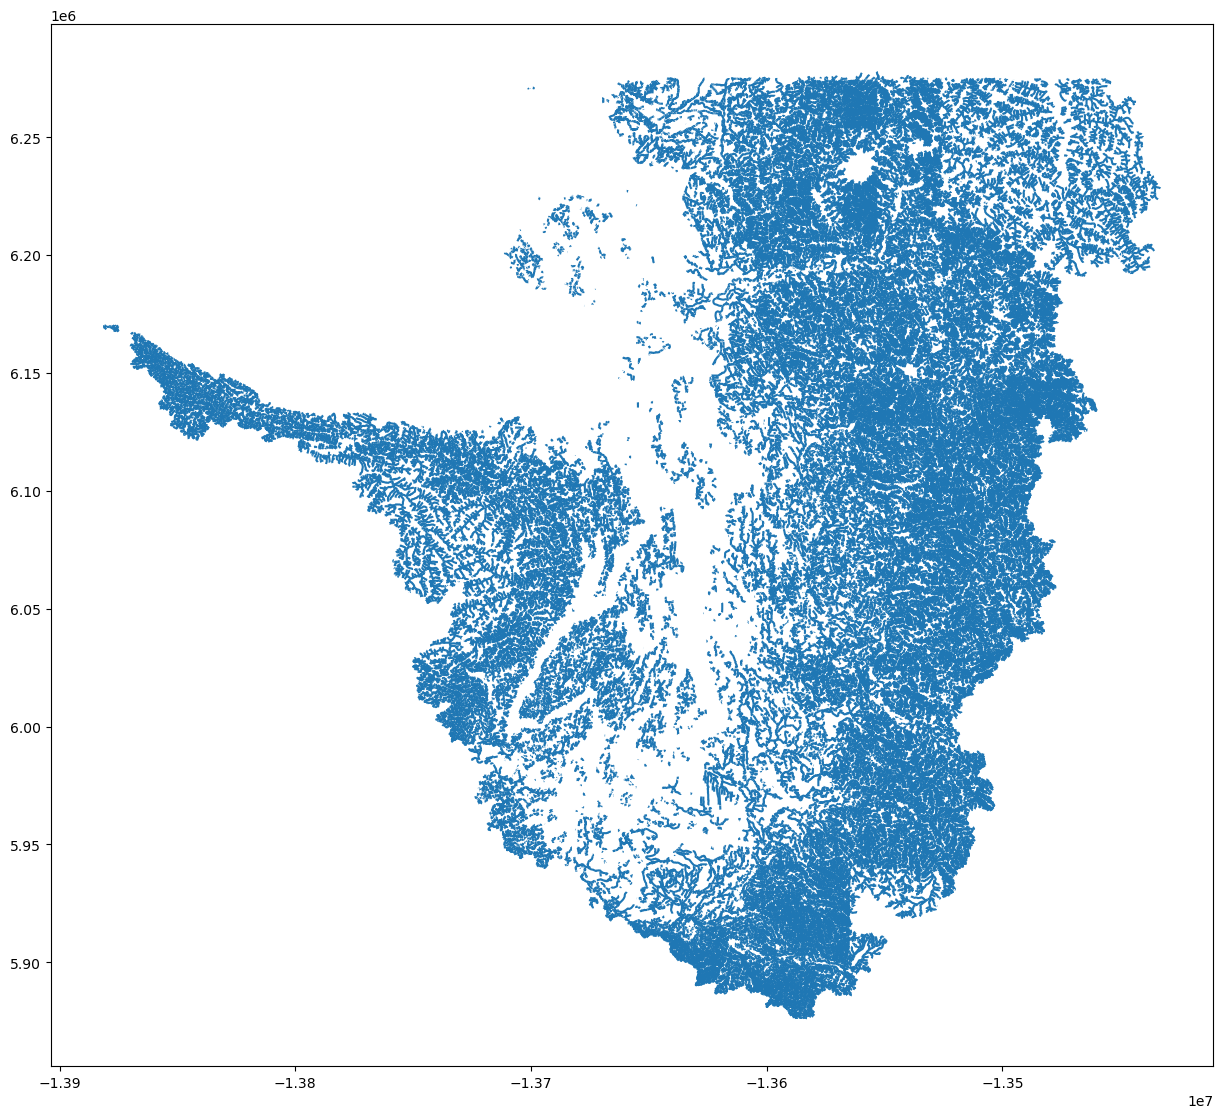

In [97]:
test = basin[basin['LengthKM']*1000 > basin['WidthM']]

fig, ax = plt.subplots(figsize=(15,15))
test.plot(ax=ax)
# reach.plot(color='r', ax=ax)
# plt.xlim(-13600000, -13500000)
# plt.ylim(5900000, 6000000)

#### CHOPPI DA SALAD

In [10]:
def cut(line, distance):
# Cuts a line in two at a distance from its starting point
# Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [106]:
reach = basin.loc[basin['LengthKM'] == 9.656000]

In [107]:
reach

,Bin,LengthKM,NHDPlusID,WidthM,geometry
204819,"(0, 10]",9.656,5.500080e+13,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...


In [136]:
reach.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [109]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry.explode().force_2d()

In [110]:
line = gs[reach.index[0]]

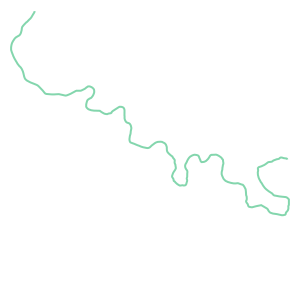

In [111]:
line

In [112]:
n = 10
dist = line.length/n

In [113]:
# Make empty GeoSeries to store all reaches
segments = gpd.GeoSeries()

# Segment the reach
for i in range(n):
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    # Convert new segment to GeoSeries for appending
    new_gs = gpd.GeoSeries(new)
    
    # Append new segment to GeoSeries of all segments
    segments = pd.concat([segments, new_gs])
# reaches = gpd.GeoSeries(reaches)

In [114]:
# Check that we got the entire reach
assert line.length < 1e-8

In [194]:
df = gpd.GeoDataFrame({'geometry':segments}, crs=reach.crs).reset_index().drop(columns='index')

In [196]:
df.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

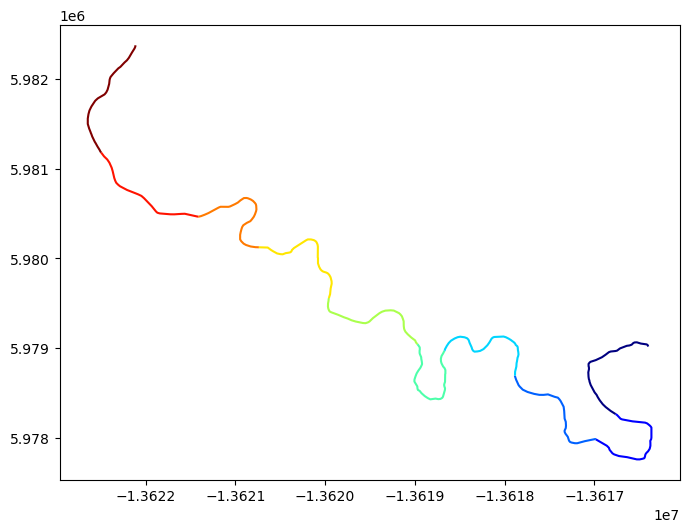

In [117]:
fig, ax = plt.subplots(figsize=(8,8))
df.plot(cmap='jet', ax=ax)

In [140]:
reach

,Bin,LengthKM,NHDPlusID,WidthM,geometry
204819,"(0, 10]",9.656,5.500080e+13,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...


In [144]:
reach.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [163]:
reach

,Bin,LengthKM,NHDPlusID,WidthM,geometry
204819,"(0, 10]",9.656,5.500080e+13,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...


In [197]:
# reach_cut = gpd.GeoDataFrame(np.repeat(a=reach.drop(columns='geometry'),
#                                       repeats=n, axis=0))
# reach_cut.columns = reach.drop(columns='geometry').columns

reach_cut = gpd.GeoDataFrame(np.repeat(a=reach, repeats=n, axis=0), columns=reach.columns,
                            crs=reach.crs)
# reach_cut = reach_cut.rename(columns={'geometry': 'geometry_full'})

In [198]:
reach_cut.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [199]:
reach_cut = gpd.GeoDataFrame(reach_cut.merge(right=df, how='right', left_index=True, right_index=True))

In [200]:
reach_cut

,Bin,LengthKM,NHDPlusID,WidthM,geometry_x,geometry_y
0,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13616401.098 5979018.668, -136164..."
1,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13616764.088 5978266.046, -136167..."
2,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13616983.566 5977984.277, -136169..."
3,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13617885.133 5978694.226, -136178..."
4,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13618670.933 5978971.263, -136186..."
5,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13618972.546 5979045.391, -136189..."
6,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13619957.613 5979558.841, -136199..."
7,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13620738.17 5980124.29, -13620775..."
8,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13621414.541 5980466.099, -136214..."
9,"(0, 10]",9.656,55000800264770.0,7.774163,MULTILINESTRING Z ((-13616401.098 5979018.668 ...,"LINESTRING (-13622495.373 5981180.212, -136225..."


In [201]:
# Drop the geometry of the full reach, set segment geometry as active geometry column
reach_cut = reach_cut.drop(columns='geometry_x').rename(columns={'geometry_y': 'geometry'})

In [204]:
reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')

(5979000.0, 5980000.0)

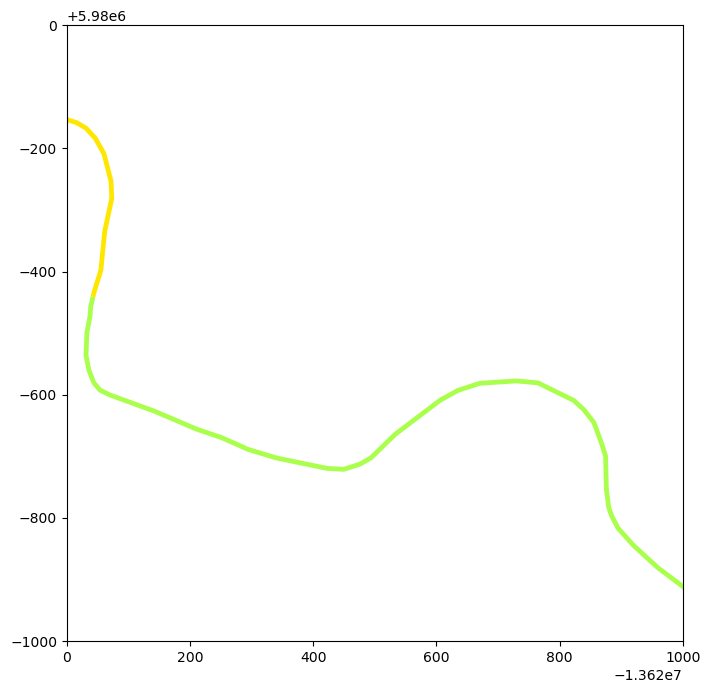

In [205]:
fig, ax = plt.subplots(figsize=(8,8))
reach_cut.plot(cmap='jet', ax=ax)

plt.xlim(-13620000,-13619000)
plt.ylim(5979000,5980000)

In [307]:
bounds_wm = reach_cut.total_bounds
bounds_wgs = reach_cut.to_crs(epsg=4326).total_bounds

#### Get Pixel Cloud

In [208]:
pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0', 
                                       bounding_box = (bounds_wgs[0], bounds_wgs[1],
                                                      bounds_wgs[2], bounds_wgs[3]))

In [ ]:
# Download all granules (function checks if files already exist)
earthaccess.download(pixc_results, "../data_downloads")

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1803.23it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]


['../data_downloads/SWOT_L2_HR_PIXC_474_013_237L_20230329T085422_20230329T085433_PGC0_01.nc']

In [321]:
files = os.listdir('../data_downloads/')

In [322]:
len(files)

2881

In [213]:
filepath = '../data_downloads/SWOT_L2_HR_PIXC_474_013_237L_20230329T085422_20230329T085433_PGC0_01.nc'

In [216]:
ds_PIXC = xr.open_mfdataset(filepath, group = 'pixel_cloud', engine='h5netcdf')

In [254]:
# mask = np.where(np.logical_and(ds_PIXC.classification > 2, ds_PIXC.geolocation_qual < 1))
mask = np.where(ds_PIXC.classification > 2)

In [292]:
test = gpd.GeoDataFrame(ds_PIXC.classification[mask],
                        geometry=gpd.points_from_xy(ds_PIXC.longitude[mask],
                                                    ds_PIXC.latitude[mask]),
                        crs="EPSG:4326")
test.rename(columns={test.columns[0]: 'klass'}, inplace=True)

In [305]:
test = test.to_crs(epsg=3857)

In [306]:
test.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [308]:
polygon = box(bounds_wm[0], bounds_wm[1], bounds_wm[2], bounds_wm[3])

In [309]:
crop = test.clip(polygon)

<Axes: >

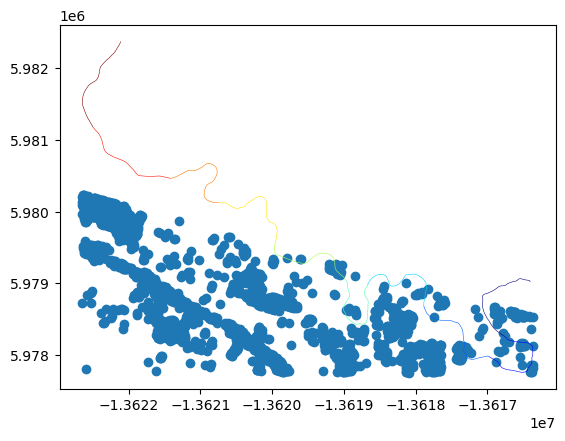

In [311]:
fig, ax = plt.subplots()
crop.plot(ax=ax)
reach_cut.plot(cmap='jet', ax=ax)

#### Sjoin

In [312]:
inside = gpd.sjoin(crop, reach_cut, how='inner', predicate='within')

<Axes: >

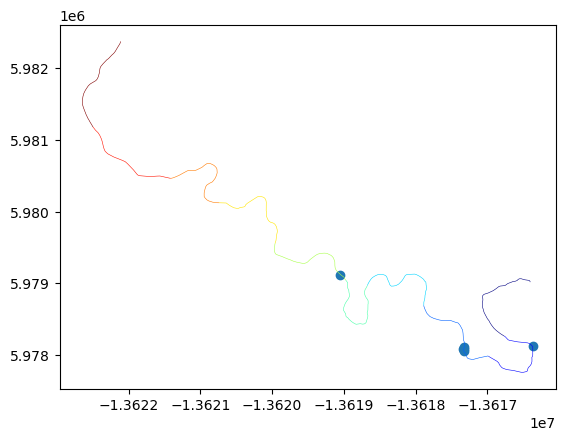

In [315]:
fig, ax = plt.subplots()
inside.plot(ax=ax)
reach_cut.plot(cmap='jet', ax=ax)

#### Digging into whether all the granules I got back are empty and/or in my bounding box

In [325]:
bounds = basin.to_crs(epsg=4326).total_bounds

In [406]:
# HUC2 1711
basin_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                  bounding_box = (bounds[0], bounds[1],
                                                  bounds[2], bounds[3]))

In [408]:
len(basin_results)

5226

In [409]:
# All of CONUS
conus_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                  bounding_box = (-124.848974, 24.396308,
                                                  -66.885444, 49.384358))

In [411]:
len(conus_results)

157689

In [383]:
# Testing these very small files
# filepath = '../data_downloads/'

# 2.69 MB, says is has points but they have no geometry
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_008_297_158R_20231224T210356_20231224T210407_PGC0_01.nc'

# 9.64 MB, has data! BUT IT'S IN THE MIDDLE OF THE OCEAN
# -20.58, -172.30
filepath = '../data_downloads/SWOT_L2_HR_PIXC_008_390_191L_20231228T045357_20231228T045408_PGC0_02.nc'

# 10.4 MB, says is has points but they have no geometry
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_008_395_161R_20231228T090615_20231228T090626_PGC0_02.nc'

# 11.8 MB, has data!
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_008_390_191L_20231228T045357_20231228T045408_PGC0_02.nc'

# 13.4 MB, has data!
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_009_246_085R_20240112T215258_20240112T215300_PGC0_01.nc'

# 15.1 MB, has data!
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_008_478_144R_20231231T081327_20231231T081328_PGC0_02.nc'

# 21.9 MB, has data!
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_008_298_180R_20231224T215859_20231224T215910_PGC0_01.nc'

# 33.5 MB, has data!
# filepath = '../data_downloads/SWOT_L2_HR_PIXC_009_368_168L_20240117T064321_20240117T064322_PGC0_02.nc'
ds = xr.open_mfdataset(filepath, group = 'pixel_cloud', engine='h5netcdf')

In [384]:
ds

<xarray.Dataset> Size: 31MB
Dimensions:                                (points: 110511, complex_depth: 2,
                                            num_pixc_lines: 3275)
Coordinates:
    latitude                               (points) float64 884kB dask.array<chunksize=(110511,), meta=np.ndarray>
    longitude                              (points) float64 884kB dask.array<chunksize=(110511,), meta=np.ndarray>
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 884kB dask.array<chunksize=(110511,), meta=np.ndarray>
    range_index                            (points) float64 884kB dask.array<chunksize=(110511,), meta=np.ndarray>
    interferogram                          (points, complex_depth) float32 884kB dask.array<chunksize=(110511, 2), meta=np.ndarray>
    power_plus_y                           (points) float32 442kB dask.array<chunksize=(110511,), meta=np.ndarray>
    power_minus_y                          (points) float32 442kB dask.array<chunksize=(110511,), meta=np.ndarray>
    coherent_power                         (points) float32 442kB dask.array<chunksize=(110511,), meta=np.ndarray>
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB dask.array<chunksize=(3275,), meta=np.ndarray>
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB dask.array<chunksize=(3275,), meta=np.ndarray>
    data_window_first_valid                (num_pixc_lines) float64 26kB dask.array<chunksize=(3275,), meta=np.ndarray>
    data_window_last_valid                 (num_pixc_lines) float64 26kB dask.array<chunksize=(3275,), meta=np.ndarray>
    data_window_first_cross_track          (num_pixc_lines) float32 13kB dask.array<chunksize=(3275,), meta=np.ndarray>
    data_window_last_cross_track           (num_pixc_lines) float32 13kB dask.array<chunksize=(3275,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3275
    interferogram_size_range:    5528
    looks_to_efflooks:           1.550024190574571
    num_azimuth_looks:           7.0
    azimuth_offset:              5

In [402]:
small = gpd.GeoDataFrame(ds.classification,
                         geometry=gpd.points_from_xy(ds.longitude,
                                                    ds.latitude),
                         crs="EPSG:4326")
small.rename(columns={test.columns[0]: 'klass'}, inplace=True)

In [403]:
small

,0,geometry
0,1.0,POINT (-172.30105 -20.58908)
1,1.0,POINT (-172.30108 -20.58908)
2,1.0,POINT (-172.30116 -20.58909)
3,1.0,POINT (-172.30111 -20.58909)
4,1.0,POINT (-172.30074 -20.58903)
...,...,...
110506,1.0,POINT (-172.1757 -21.15535)
110507,1.0,POINT (-172.17441 -21.15515)
110508,1.0,POINT (-172.17306 -21.15494)
110509,1.0,POINT (-172.17132 -21.15466)


In [404]:
small.bounds

,minx,miny,maxx,maxy
0,-172.301047,-20.589076,-172.301047,-20.589076
1,-172.301083,-20.589082,-172.301083,-20.589082
2,-172.301159,-20.589094,-172.301159,-20.589094
3,-172.301114,-20.589087,-172.301114,-20.589087
4,-172.300736,-20.589028,-172.300736,-20.589028
...,...,...,...,...
110506,-172.175703,-21.155351,-172.175703,-21.155351
110507,-172.174415,-21.155148,-172.174415,-21.155148
110508,-172.173062,-21.154936,-172.173062,-21.154936
110509,-172.171320,-21.154662,-172.171320,-21.154662


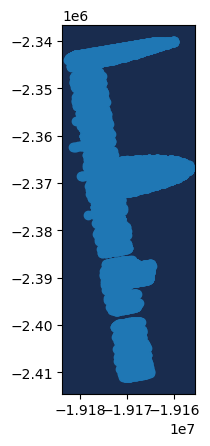

In [399]:
# mask = np.where(ds.classification > 2)
# plt.scatter(x=ds.longitude, y=ds.latitude, c=ds.height, cmap='jet')
fig, ax = plt.subplots()
small.plot(ax=ax)

# Sentinel 2 basemap
s2 = 'https://tiles.maps.eox.at/wmts/1.0.0/s2cloudless-2018_3857/default/g/{z}/{y}/{x}.jpg'
cx.add_basemap(ax, crs=small.crs, source=s2
                # ctx.providers.Esri.NatGeoWorldMap
                # ctx.providers.CartoDB.Positron
                # Esri.NatGeoWorldMap
                ,
                alpha=1, 
                zoom=10)
# plt.clim((0,100))

In [387]:
small = small.to_crs(epsg=3857)

In [388]:
small.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [389]:
polygon = box(bounds_wm[0], bounds_wm[1], bounds_wm[2], bounds_wm[3])

In [390]:
crop = small.clip(polygon)

### SCRATCH2

In [ ]:
# import fiona
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
# import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

In [ ]:
## Set-up
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/'

In [ ]:
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

In [ ]:
# Get slurm job index
i = 109

# Get current HUC2 and HUC4 IDs
hu2 = 'HUC2_' + lookup.loc[i,'HUC4'][0:2]
hu4 = 'NHDPLUS_H_' + lookup.loc[i,'HUC4'] + '_HU4_GDB'

In [ ]:
# Set data filepath
file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg')

In [ ]:
# fiona.listlayers(file_path)

In [ ]:
# fieldsF = ['GNIS_ID', 'GNIS_Name', 'LengthKM',  'FlowDir',
#            'WBArea_Permanent_Identifier', 'FType', 'FCode',
#            'NHDPlusID', 'VPUID', 'geometry']
# fieldsVAA = ['NHDPlusID', 'StreamOrde', 'FromNode', 'ToNode',
#             'LevelPathI', 'TerminalFl', 'TotDASqKm', 'VPUID']
# fieldsEROMMA = ['NHDPlusID', 'QBMA', 'VPUID']

In [ ]:
# Read in NHD flowlines
features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')

In [ ]:
basin.shape

In [ ]:
# Drop reaches that are shorter than their width
basin = basin[basin['LengthKM']*1000 > basin['WidthM']]

In [ ]:
basin.shape

In [ ]:
# for binn in bins:
#     print(basin.loc[basin['Bin'] == binn].sample(n=1))

#### Width analysis

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
basin.plot(ax=ax)
# basin[basin['LengthKM'] == 16.387000].plot(color='r', ax=ax)

In [ ]:
basin.Bin.unique()

In [ ]:
# order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
#          '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
#          '(100, 150]', '(150, 200]']
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(80, 90]']

In [ ]:
basin['Bin'].value_counts().loc[order].plot.bar(color='k')
plt.title(hu4)
plt.xlabel('Bankfull widths (m)')
plt.ylabel('Number of reaches')

In [ ]:
min_width = basin.groupby('Bin').min('LengthKM')['LengthKM']
mean_width = basin.groupby('Bin').mean('LengthKM')['LengthKM']
med_width = basin.groupby('Bin').median('LengthKM')['LengthKM']
max_width = basin.groupby('Bin').max('LengthKM')['LengthKM']

print('Reach length by bin\n')
print('Width (m)\t' +  'Min(m)\t' + 'Mean(m)\t' + 'Med(m)\t' + 'Max(m)\t')
for i in order:
    print(i + ':\t' + str(round(min_width.loc[i], 3)*1000) + '\t' +
          str(round(mean_width.loc[i], 3)*1000) + '\t' +
          str(round(med_width.loc[i], 3)*1000) + '\t' +
          str(round(max_width.loc[i], 3)*1000))

In [ ]:
basin[basin['LengthKM'] > 8.0]

In [ ]:
reach = basin.loc[basin['LengthKM'] > 10]

In [ ]:
reach

In [ ]:
test = reach.LengthKM.item()

In [ ]:
print(reach.GNIS_Name.item() + ", " + reach.Permanent_Identifier.item() +
          ", Length: " + str(round(reach.LengthKM.item(),3)) + "km, Width: " +
          str(round(reach.WidthM.item(),3)) + 'm')

In [ ]:
reach = basin[basin['LengthKM'] > 10];

fig, ax = plt.subplots(figsize=(15,15))
basin.plot(ax=ax)
reach.plot(color='r', ax=ax)
plt.title(reach.GNIS_Name.item() + ", " + reach.Permanent_Identifier.item() +
          ", Length: " + str(round(reach.LengthKM.item(),3)) + "km, Width: " +
          str(round(reach.WidthM.item(),3)) + 'm')

In [ ]:
basin.shape

In [ ]:
basin[basin['LengthKM']*1000 < basin['WidthM']*20]

In [ ]:
test = basin[basin['LengthKM']*1000 > basin['WidthM']]

fig, ax = plt.subplots(figsize=(15,15))
test.plot(ax=ax)
# reach.plot(color='r', ax=ax)
# plt.xlim(-13600000, -13500000)
# plt.ylim(5900000, 6000000)

#### CHOPPI DA SALAD

In [ ]:
def cut(line, distance):
# Cuts a line in two at a distance from its starting point
# Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [ ]:
np.max(basin.LengthKM)

In [ ]:
reach = basin.loc[basin['NHDPlusID'] == 55000800282287]
# reach = basin.loc[basin['LengthKM'] == 10.11085088]
# reach = basin.loc[basin['LengthKM'] == 9.656000]

In [ ]:
reach

In [ ]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry.explode().force_2d()

In [ ]:
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
# line

In [ ]:
# Define number of segments
n = 10
dist = line.length/n

In [ ]:
line.length

In [ ]:
dist

In [ ]:
# Make empty list for segments
segments = []

# Segment the reach
for i in range(n):
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    
    # Append new segment to GeoSeries of all segments
    segments.append(new)
# reaches = gpd.GeoSeries(reaches)

In [ ]:
# Check the remainder to ensure we got the entire reach
assert line.length < 1e-8

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
df.plot(cmap='jet', ax=ax)

In [ ]:
# # Duplicate rows of original reach metadata for merging
# reach_cut = gpd.GeoDataFrame(np.repeat(a=reach, repeats=n, axis=0), columns=reach.columns,
#                             crs=reach.crs)

In [ ]:
# # Check that CRS match before merging
# assert reach_cut.crs == df.crs

In [ ]:
# # Merge the new segments onto the metadata
# reach_cut = gpd.GeoDataFrame(reach_cut.merge(right=df, how='right', left_index=True, right_index=True))

In [ ]:
# # Drop the geometry of the full reach, set segment geometry as active geometry column
# reach_cut = reach_cut.drop(columns='geometry_x').rename(columns={'geometry_y': 'geometry'})

In [ ]:
d = {}

for i in range(reach_cut.shape[1]):
    d[reach_cut.iloc[:,i].name] = reach_cut.iloc[i,i]

d['geometry_full'] = d['geometry']

In [ ]:
test = gpd.GeoDataFrame(index=range(len(segments)), data=d, geometry=segments)

In [ ]:
reach_cut.iloc[:,0].name

In [ ]:
# reach_cut

In [ ]:
# Buffer the reach segments by 1/2 the calculated width
# CITE BEIGER
reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
reach_cut.plot(cmap='jet', ax=ax)

# # plt.xlim(-13620000,-13619000)
# plt.ylim(5968000,5970000)

In [ ]:
# Get the bounds for Earthdata (EPSG:4326) and analysis (EPSG:3857)
bounds_proj = reach_cut.total_bounds
bounds_geo = reach_cut.to_crs(epsg=4326).total_bounds

#### Get Pixel Cloud

In [ ]:
filepath = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'

In [ ]:
ds_PIXC = xr.open_mfdataset(filepath, group = 'pixel_cloud', engine='h5netcdf')

In [ ]:
ds_PIXC

In [ ]:
# When I also filter on the qual flags like Brent does in the PO.DAAC cookbook,
# I get no pixels
mask = np.where(ds_PIXC.classification > 2)
# mask = np.where(np.logical_and(ds_PIXC.classification > 2, ds_PIXC.geolocation_qual < 4))

In [ ]:
gdf_PIXC = gpd.GeoDataFrame(ds_PIXC.classification[mask],
                        geometry=gpd.points_from_xy(ds_PIXC.longitude[mask],
                                                    ds_PIXC.latitude[mask]),
                        crs="EPSG:4326")
gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)

In [ ]:
gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)

#### For now: Get bounds of PIXC and crop basin to it

In [ ]:
# Get bounds of PIXC, construct polygon
bounds_PIXC = gdf_PIXC.total_bounds
poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [ ]:
crop_basin = basin.clip(poly)

In [ ]:
bins = np.unique(crop_basin.Bin)
bins

##### To just see pixels in bounding box

In [ ]:
polygon = box(bounds_proj[0], bounds_proj[1], bounds_proj[2], bounds_proj[3])

In [ ]:
crop_PIXC = gdf_PIXC.clip(polygon)

In [ ]:
fig, ax = plt.subplots()
reach_cut.plot(cmap='jet', ax=ax)
crop_PIXC.plot(ax=ax, alpha=0.5)

#### Sjoin

In [ ]:
inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

In [ ]:
np.unique(inside.klass)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
reach_cut.plot(cmap='jet', alpha=0.5, ax=ax)
inside.plot(column=inside.klass, categorical=True, 
            markersize=3, c=inside.klass, ax=ax, legend=True)

leg1 = ax.get_legend()
leg1.set_title("Classification")

In [ ]:
counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())

In [ ]:
counts

In [ ]:
coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)

In [ ]:
coverage

In [ ]:
d = {'coverage': [0, 1, 2], 'test': 0}

In [ ]:
tt = pd.DataFrame(data=d, index=[0, 1, 2])

In [ ]:
tt

In [ ]:
# inside

#### Loop the chop

In [ ]:
def segmentReach(reach):
    ###
    
    # Convert MultiLineString Z to LineString (returns GeoSeries)
    gs = reach.geometry.explode().force_2d()
    # Extract line segment from GeoSeries
    line = gs[reach.index[0]]
    print(line.length)
    # Find length of segments
    dist = line.length/10
    print(dist)
    
    # Make empty list for segments
    segments = []
    
    # Segment the reach
    for i in range(10):
        # Chop the reach, store remainder
        new, remain = cut(line=line, distance=dist)

        # Append new segment to GeoSeries of all segments
        segments.append(new)
    
    # Check the remainder to ensure we got the entire reach
    assert linne.length < 1e-8
    del new, linne, dist
    
    # Make dict for constructing new GeoDataFrame
    d = {}
    for i in range(reach.shape[1]):
        d[reach.iloc[:,i].name] = reach.iloc[0,i]
    # Rename geometry for full reach
    d['geometry_full'] = d['geometry']
    
    # Make GeoDataFrame with new reach segments
    reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
                                 geometry=segments, crs=reach.crs)
    
    return reach_cut

In [ ]:
def getCoverage(gdf_PIXC, reach_cut):
    ###
    
    # Get pixels in reach
    inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

    if inside.empty:
        coverage = 0
    else:    
        # Get number of pixels in each reach segment
        counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
        # Calculate coverage
        coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)
    
    return coverage

In [ ]:
# Initialize lists
coverage = []
reach_bins = []

for binn in bins:
    reach = crop_basin.loc[crop_basin['Bin'] == binn].sample(n=1)
    '{}'.format(reach.NHDPlusID)
    # break
    reach_bins.append(reach.iloc[0,0])
    
    # Get reach segments
    reach_cut = segmentReach(reach)
    
    # Get coverage for reach
    prop = getCoverage(gdf_PIXC, reach_cut)
    
    coverage.append(prop)

In [ ]:
reach

In [ ]:
n = 10

In [ ]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry.explode().force_2d()
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
# Find length of segments
dist = line.length/n

In [ ]:
line.length

In [ ]:
dist

In [ ]:
# Make empty list for segments
segments = []

In [ ]:
# Segment the reach
for i in range(n):
    print(i)
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)

    # Append new segment to GeoSeries of all segments
    segments.append(new)

In [ ]:
segments

In [ ]:
# Check the remainder to ensure we got the entire reach
assert line.length < 1e-8

# Make dict for constructing new GeoDataFrame
d = {}
for i in range(reach.shape[1]):
    d[reach.iloc[:,i].name] = reach.iloc[i,i]
# Rename geometry for full reach
d['geometry_full'] = d['geometry']

# Make GeoDataFrame with new reach segments
reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)), geometry=segments)

In [2]:
# One way to do that is to use interpolate method that returns points at specified distances along the line.
# You just have to generate a list of the distances somehow first. Taking the input line example from Roy2012's answer:
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, mapping, shape
from shapely.ops import split, unary_union

In [3]:
line = LineString(([0, 0], [2, 1], [3, 2], [3.5, 1], [5, 2]))

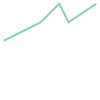

In [4]:
line

In [5]:
# Splitting at a specified distance:
n = 10
distance_delta = line.length/n
distances = np.arange(0, line.length, distance_delta)

In [6]:
distances

array([0.        , 0.65710912, 1.31421823, 1.97132735, 2.62843647,
       3.28554558, 3.9426547 , 4.59976382, 5.25687293, 5.91398205])

In [7]:
points = [line.interpolate(distance) for distance in distances]
multipoint = unary_union(points)  # or new_line = LineString(points)

<Axes: >

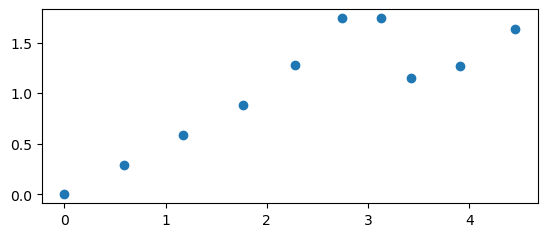

In [8]:
gpd.GeoSeries(points).plot()

In [9]:
test = split(line, multipoint)

In [10]:
print(shape(mapping(test)))

GEOMETRYCOLLECTION (LINESTRING (0 0, 0.5877362613727062 0.2938681306863531), LINESTRING (0.5877362613727062 0.2938681306863531, 1.1754725227454124 0.5877362613727062), LINESTRING (1.1754725227454124 0.5877362613727062, 1.7632087841181185 0.8816043920590593), LINESTRING (1.7632087841181185 0.8816043920590593, 2 1, 2.2774464193256025 1.2774464193256025), LINESTRING (2.2774464193256025 1.2774464193256025, 2.7420927316780506 1.7420927316780506), LINESTRING (2.7420927316780506 1.7420927316780506, 3 2, 3.5 1, 4.453252166091371 1.635501444060914), LINESTRING (4.453252166091371 1.635501444060914, 5 2))


In [12]:
tt = test.explode()

AttributeError: 'GeometryCollection' object has no attribute 'explode'

In [13]:
tt = gpd.GeoSeries(test)

In [17]:
tt = tt.explode()

<Axes: >

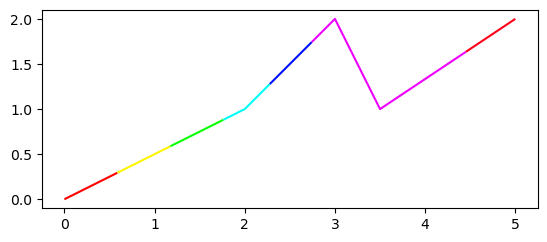

In [18]:
tt.plot(cmap='hsv')

In [38]:
type(test)

shapely.geometry.collection.GeometryCollection

In [ ]:
# One way to do that is to use interpolate method that returns points at specified distances along the line. You just have to generate a list of the distances somehow first. Taking the input line example from Roy2012's answer:

import numpy as np
from shapely.geometry import LineString
from shapely.ops import unary_union

line = LineString(([0, 0], [2, 1], [3, 2], [3.5, 1], [5, 2]))

# Splitting at a specified distance:

distance_delta = 0.9
distances = np.arange(0, line.length, distance_delta)
# or alternatively without NumPy:
# points_count = int(line.length // distance_delta) + 1
# distances = (distance_delta * i for i in range(points_count))
points = [line.interpolate(distance) for distance in distances] + [line.boundary[1]]
multipoint = unary_union(points)  # or new_line = LineString(points)

# Note that since the distance is fixed you can have problems at the end of the line as shown in the image. Depending on what you want you can include/exclude the [line.boundary[1]] part which adds the line's endpoint or use distances = np.arange(0, line.length, distance_delta)[:-1] to exclude the penultimate point.

# Also, note that the unary_union I'm using should be more efficient than calling object.union(other) inside a loop, as shown in another answer.
# Splitting to a fixed number of points:

n = 7
# or to get the distances closest to the desired one:
# n = round(line.length / desired_distance_delta)
distances = np.linspace(0, line.length, n)
# or alternatively without NumPy:
# distances = (line.length * i / (n - 1) for i in range(n))
points = [line.interpolate(distance) for distance in distances]
multipoint = unary_union(points)  # or new_line = LineString(points)

In [ ]:
# Get distance for translation
width = 1
mid_coord = substring(orthogonal, 0, width/2).coords[1]
mid_pt = Point(mid_coord)
mid_dist = nadir.project(mid_pt)

In [118]:
width = 1
height = 3

In [7]:
# Test nadir track
nadir = LineString([[1,1], [2,4]])

In [15]:
# Test pixel centroid
pixel = Point([2,2])

In [31]:
pixel.coords[0]

(2.0, 2.0)

In [19]:
# Get distance along nadir track closest to pixel centroid
dist = nadir.project(pixel)

In [82]:
dist

np.float64(1.264911064067352)

In [28]:
# Get coordinate of point along nadir closest to pixel centroid
projection = substring(nadir, 0, dist).coords[1]

In [33]:
# Create linestring from pixel to closest point on nadir track
orthogonal = LineString([pixel.coords[0], projection])

In [119]:
mid_point = Point(substring(geom=orthogonal, start_dist=0, end_substring(orthogonal, 0, width/2)dist=width/2))

TypeError: 'LineString' object is not iterable

In [114]:
mid_dist = orthogonal.length - width/2

In [116]:
left_edge = nadir.parallel_offset(distance=mid_dist, side='right')
right_edge = nadir.parallel_offset(distance=mid_dist+width, side='right')

In [62]:
# left_edge = translate(geom=nadir, xoff=edge_dist, yoff=edge_dist)
# right_edge = translate(geom=nadir, xoff=edge_dist+width, yoff=edge_dist+width)
# left_gs = gpd.GeoSeries(left_edge)

<Axes: >

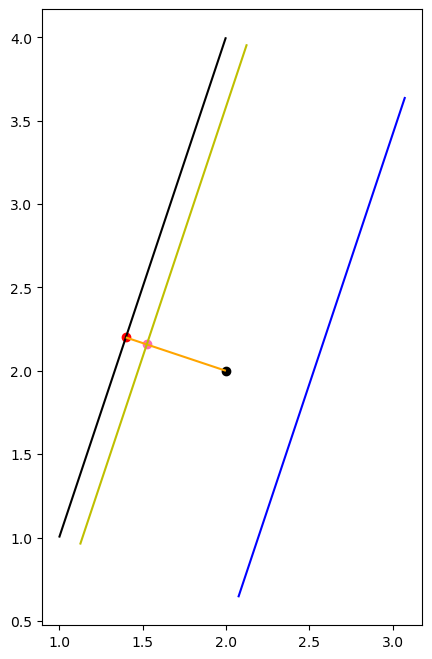

In [117]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(nadir).plot(ax=ax, color='k')
gpd.GeoSeries(pixel).plot(ax=ax, color='k')

gpd.GeoSeries(Point(projection)).plot(ax=ax, color='r')
gpd.GeoSeries(orthogonal).plot(ax=ax, color='orange')
gpd.GeoSeries(mid_pt).plot(ax=ax, color='hotpink')

gpd.GeoSeries(right_edge).plot(ax=ax, color='b')
gpd.GeoSeries(left_edge).plot(ax=ax, color='y')


**Using translate**